In [38]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
 # Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability) 

In [0]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x


def meanpool2d(x, k=2):
    
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1_ = conv2d(x, weights['wc1'], biases['bc1'])
#     with sess.as_default():
#         print(conv1.eval())
#         print("   /n/n")
    
    # Max Pooling (down-sampling)
    conv1 = meanpool2d(conv1_, k=2)

    # Convolution Layer
    conv2_ = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = meanpool2d(conv2_, k=2)
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1_ = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1_, weights['wd1']), biases['bd1'])
    #fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1_2 = tf.nn.dropout(fc1, dropout)
    
    check = {}
    check['conv1'] = conv1_
    check['conv1mp'] = conv1
    check['conv2'] = conv2_
    check['conv2mp'] = conv2
    check['fc1_reshape'] = fc1_
    check['fc1_wb'] = fc1
    check['fc1_drp'] = fc1_2

    # Output, class prediction
    out = tf.add(tf.matmul(fc1_2, weights['out']), biases['out'])
    return out, check

In [0]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    #'wc3': tf.Variable(tf.random_normal([5, 5, 48, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    #'bc3': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits,verify = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



sess = tf.Session()
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
# Run the initializer
sess.run(init)

In [42]:
# Start training
import numpy as np
for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

print("Optimization Finished!")

# Calculate accuracy for 256 MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                  Y: mnist.test.labels[:256],
                                  keep_prob: 1.0}))

Step 1, Minibatch Loss= 98186.2422, Training Accuracy= 0.078
Step 10, Minibatch Loss= 40360.4375, Training Accuracy= 0.258
Step 20, Minibatch Loss= 11813.3145, Training Accuracy= 0.617
Step 30, Minibatch Loss= 6611.5552, Training Accuracy= 0.758
Step 40, Minibatch Loss= 8685.6875, Training Accuracy= 0.812
Step 50, Minibatch Loss= 3876.0322, Training Accuracy= 0.836
Step 60, Minibatch Loss= 4041.7061, Training Accuracy= 0.859
Step 70, Minibatch Loss= 4593.1719, Training Accuracy= 0.812
Step 80, Minibatch Loss= 3060.7913, Training Accuracy= 0.906
Step 90, Minibatch Loss= 2543.2065, Training Accuracy= 0.891
Step 100, Minibatch Loss= 4327.8271, Training Accuracy= 0.898
Step 110, Minibatch Loss= 5263.9189, Training Accuracy= 0.828
Step 120, Minibatch Loss= 4490.6333, Training Accuracy= 0.867
Step 130, Minibatch Loss= 7390.7905, Training Accuracy= 0.820
Step 140, Minibatch Loss= 1925.0941, Training Accuracy= 0.914
Step 150, Minibatch Loss= 6931.4224, Training Accuracy= 0.844
Step 160, Miniba

In [69]:
print(sess.run(logits, feed_dict={X: np.expand_dims(mnist.test.images[1,:],0),keep_prob: 1.0}))
# print(mnist.test.labels[1,:])

[[  41364.598  -12751.213  106725.44    22771.99  -143177.05    66472.21
    55097.516 -234983.45    18313.836 -130417.39 ]]


Prediction: [5] Actual: 5


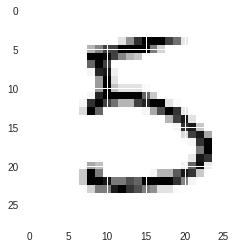

In [74]:
import matplotlib.pyplot as plt 
%matplotlib inline
idx = 15 # change value to test different image
pred = sess.run(tf.argmax(prediction,1), feed_dict={X: np.expand_dims(mnist.test.images[idx,:],0),keep_prob: 1.0})
print ("Prediction:", pred, "Actual:",np.argmax(mnist.test.labels[idx,:],-1))#tf.argmax(np.expand_dims(mnist.test.labels[1],0))#

plt.imshow(np.reshape(mnist.test.images[idx,:],(28,28)))

In [0]:
from google.colab import files

np.save('testim2.npy',mnist.test.images[15,:])
files.download('testim2.npy')

In [0]:

np.save('weights1.npy',sess.run(weights['wc1']))
files.download('weights1.npy')

In [0]:
np.save('weights2.npy',sess.run(weights['wc2']))
files.download('weights2.npy')

In [0]:
np.save('weights3.npy',sess.run(weights['wd1']))
files.download('weights3.npy')

In [0]:
np.save('weights4.npy',sess.run(weights['out']))
files.download('weights4.npy') 

In [0]:
np.save('bc1.npy',sess.run(biases['bc1']))
files.download('bc1.npy')

In [0]:
np.save('bc2.npy',sess.run(biases['bc2']))
files.download('bc2.npy')

In [0]:
np.save('bd1.npy',sess.run(biases['bd1']))
files.download('bd1.npy')

In [0]:
np.save('bout.npy',sess.run(biases['out']))
files.download('bout.npy')